# Text Classification with CNNs


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from keras.layers import TextVectorization, Input, Dense, Embedding
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D
from keras.models import Model
from keras.optimizers.legacy import Adam  # For macos compatibility

In [2]:
# Importing data
df = pd.read_csv('../datasets/spam.csv', encoding='ISO-8859-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [3]:
# Pre-processing
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# Renaming columns
df.columns = ['labels', 'data']
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
# Creating binary labels
df['binary_labels'] = df['labels'].map({'ham': 0, 'spam': 1})

# Creating target
Y = df['binary_labels']

In [6]:
# Splitting the data
df_train, df_test, Y_train, Y_test = train_test_split(
    df['data'],
    Y,
    test_size=1 / 3,
)

In [7]:
# Creating tf datasets
train_ds = tf.data.Dataset.from_tensor_slices((df_train, Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((df_test, Y_test))

In [8]:
# Converting sentences to sequences
MAX_VOCAB_SIZE = 20000
vectorization = TextVectorization(max_tokens=MAX_VOCAB_SIZE)
vectorization.adapt(train_ds.map(lambda x, y: x))

In [9]:
# Shuffle and batch the dataset
train_ds = train_ds.shuffle(buffer_size=10000).batch(32).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).prefetch(tf.data.AUTOTUNE)

In [10]:
# Getting vocab size
V = len(vectorization.get_vocabulary())

In [11]:
# Finding largest sequence to pad all sequences to that size
T = 0
for x, y in train_ds:
    t = vectorization(x).shape[1]
    if t > T:
        T = t
T

162

In [12]:
# Re-vectorizing, no need to adapt the sequences though
vectorization_2 = TextVectorization(
    max_tokens=MAX_VOCAB_SIZE,
    output_sequence_length=T,
    vocabulary=vectorization.get_vocabulary(),
)

In [13]:
# Setting the embedding dimensionality
D = 20

In [14]:
# Creating model
i = Input(shape=(1,), dtype=tf.string)
x = vectorization_2(i)
x = Embedding(V, D)(x)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [15]:
# Compile and fit model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(),
    metrics=['accuracy'],
)

r = model.fit(
    train_ds,
    epochs=5,
    validation_data=test_ds,
)

Epoch 1/5
117/117 [==============================] - 1s 5ms/step - loss: 0.3901 - accuracy: 0.8694 - val_loss: 0.2994 - val_accuracy: 0.8590
Epoch 2/5
117/117 [==============================] - 1s 5ms/step - loss: 0.1555 - accuracy: 0.9338 - val_loss: 0.0614 - val_accuracy: 0.9801
Epoch 3/5
117/117 [==============================] - 1s 5ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.0562 - val_accuracy: 0.9833
Epoch 4/5
117/117 [==============================] - 1s 5ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 0.0707 - val_accuracy: 0.9828
Epoch 5/5
117/117 [==============================] - 1s 5ms/step - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0752 - val_accuracy: 0.9822


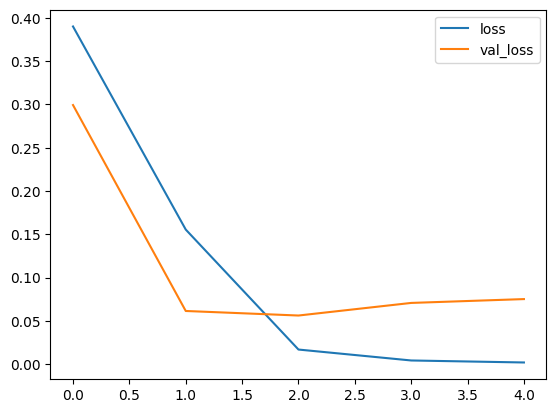

In [16]:
# Plotting model loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

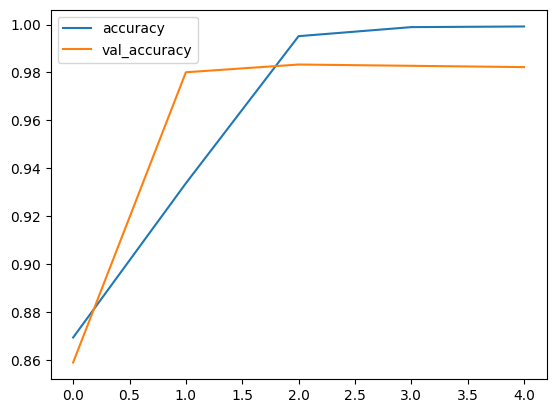

In [17]:
# Plotting model accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
# Measuring f1 score for training data
f1_score(Y_train, model.predict(df_train.values) > 0.5)

117/117 [==============================] - 0s 2ms/step


0.9989701338825953

In [19]:
# Measuring f1 score for testing data
f1_score(Y_test, model.predict(df_test.values) > 0.5)

59/59 [==============================] - 0s 2ms/step


0.9336016096579477